In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint
import sys

In [2]:
# Physical constant
e = 1.6e-19 #[C] electron charge 
M_i = 32*1.6605e-27 #[kg] ion mass
m = 9.11e-31 #[kg] electron mass
k = 1.38e-23 #[m2 kg /s2 K] Boltzmann constant

# Experimental constant
p = 10/7.5 #[mTorr to Pa]
R = 3e-3 #[m] plasma half-width
L = 33e-2 #[m] chamber length
Tg = 300 #[K] gas temperature
R_0 = 2.5e-2 #[m] chosen normalization length
B_0 = 0.03 #[T] magnetic field
gamma = 20 # electron-ion temperature ratio Te/Ti
Te = 8 #[eV] electron temperature
Ti = Te/gamma
n_g = p/k/Tg #[m-3] neutral gas density
n_e0 = n_g * 2.75e-4 #experimental condition
alpha_0 = 1
n_n0 = alpha_0/n_e0

In [3]:
class fluid_model():
    def calculation(self, eqn, X):
        E = eqn[0]
        N = eqn[1]
        U = eqn[2]
        V = eqn[3]
        W = eqn[4]
        Phi = eqn[5]
        
        K_iz =  2.34e-15*Te**1.03*np.exp(-12.29/Te) #[m3/s]
        K_att = 1.07e-15*Te**-1.391*np.exp(-6.26/Te) #[m3/s]
        K_rec = 5.2e-14*(0.026/Ti)**0.44 #[m3/s]
        nu_i = 3.95e-16*n_g #[s-1]
        nu_e = 4.7e-14*Te**0.5*n_g #[s-1]
        nu_n = 3.95e-16*n_g #[s-1]
        
        w_ce = e*B_0/m
        Di = e*Ti/(M_i*nu_i)
        nu_L = 2*Di/(R*L)*(1+Te/Ti)**0.5
        
        G = n_g/n_e0
        Cs = np.sqrt(e*Te/M_i)
        A_i = n_e0*R_0*K_iz/Cs
        A_a = n_e0*R_0*K_att/Cs
        B_i = n_e0*R_0*K_rec/Cs
        C_i = R_0*nu_i/Cs
        C_e = R_0*nu_e/Cs
        C_n = R_0*nu_n/Cs
        Omega = R_0*w_ce/Cs 
        Epsilon_i = gamma #Te/Ti는 설정값으로줌
        Epsilon_n = gamma #Te/Tn, Ti=Tn
        Zeta = 1 #M_i/M_n, Mi=Mn
        D = R_0*nu_L/Cs
        Del = (A_i+A_a)*G+C_e
        Delta = Del*(m/M_i)*(1+Omega**2/Del**2)

        M = np.array([[V, 0, 0, E, 0, 0],
                      [U, U, (E+N), 0, 0, 0],
                      [0, W, 0, 0, N, 0],
                      [1, 0, 0, 0, 0, E],
                      [1/Epsilon_i+U**2, 1/Epsilon_i+U**2, 2*(E+N)*N, 0, 0, -(E+N)],
                      [0, Zeta/Epsilon_n+W**2, 0, 0, 2*N*W, Zeta*N]])

        RHS = np.array([(A_i-A_a)*G*E-D*(E+N),
                        A_i*G*E-B_i*(E+N)*N-D*(E+N),
                        A_a*G*E-B_i*(E+N)*N,
                        -Delta*E*V,
                        -C_i*(E+N)*U,
                        -C_n*N*W])
        result = np.linalg.solve(M,RHS)
        return result
    
    def integration(self):
        x0 = [1, 1, 2, 0.5, 0.5, 3] #E, N, U, V, W, Phi
        self.X = np.linspace(0,1,1000)
        ans = odeint(self.calculation, x0, self.X, rtol=10**-3, mxstep=10**6)
        print(ans)
        self.sol_E = ans[:,0]
        #print(ans[500])
        self.sol_N = ans[:,1]
        self.sol_I = ans[:,0]+ans[:,1]
        self.sol_U = ans[:,2]
        self.sol_V = ans[:,3]
        self.sol_W = ans[:,4]
        self.sol_Phi = ans[:,5]
        
    def visualize(self):
        plt.figure(figsize=(16,8))
        
        plt.plot(self.X, self.sol_E)
        plt.plot(self.X, self.sol_N)
        plt.plot(self.X, self.sol_I)
        #plt.plot(self.X, self.sol_Phi)
        plt.xlabel('Normalized position')
        plt.ylabel('Normalized densities')
        plt.legend(['Electron','Negative','Positive'])
        #plt.ylim(0,1)
        plt.grid(True)
        
#         plt.subplot(422)
#         plt.plot(self.X, self.sol_N)
#         plt.xlabel('Normalized x')
#         plt.ylabel('Normalized density(N)')
#         plt.grid(True)
#         plt.subplots_adjust(hspace = 0.5)
        
#         plt.show()

[[1.         1.         2.         0.5        0.5        3.        ]
 [0.96525411 1.04072305 1.99703984 0.52420256 0.48047151 3.00724869]
 [0.9311254  1.0829373  1.99188604 0.54958169 0.46175399 3.01376774]
 ...
 [       nan        nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan]]


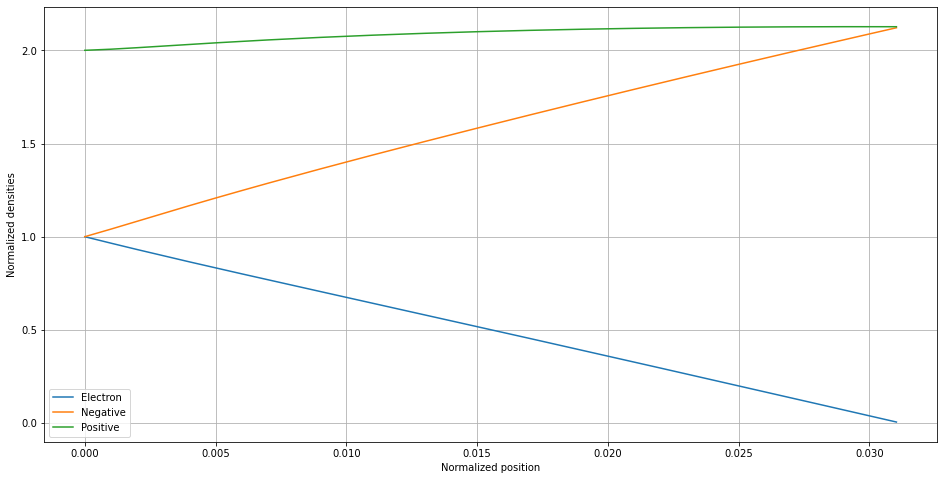

In [4]:
test_model = fluid_model()
test_model.integration()
test_model.visualize()